This project aims to create a machine learning model that predicts stock market trends, specifically focusing on predicting the target value for the next day. The goal is to help decide whether a stock is suitable for buying or selling based on its predicted behavior. The model uses historical stock data to make these predictions and applies advanced techniques to make the process more accurate and efficient.

# **Key Goals of the Project:**

1. **Predicting Future Trends** (Time-Series Forecasting): The goal is to predict the stock's value for the next day by analyzing past stock prices, trading volumes, and other relevant information.


2. **Creating Features** (Feature Engineering): The model creates new features from the historical data, such as:

  **Lag features**:

  Previous day's data to spot patterns.

  **Rolling statistics**:

  Average values over time (e.g., 20-day moving average).

  **Technical indicators**:

  Measurements like volatility (how much the stock price changes) and Average True Range (ATR) (a measure of stock price movement).


3. **Validating Predictions** (Cross-Validation): The model is tested on different parts of the data to check if it performs well in real-world situations, making sure it doesn't just memorize past data but can generalize to new data.


4. **Optimizing the Model** (Model Optimization): LightGBM, a machine learning algorithm, is used for its ability to handle large data efficiently and its ability to work with stock symbols as categories, making it well-suited for this type of prediction task.

In [ ]:
#!pip install optuna

In [ ]:
#pip install optuna optuna-integration[lightgbm]


In [ ]:
import warnings, gc
import numpy as np
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import joblib
from google.colab import drive
#import optuna
#from optuna.integration import LightGBMPruningCallback


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))

colors=px.colors.qualitative.Plotly

train=pd.read_csv('/content/drive/My Drive/Stock data/stock_prices.csv', parse_dates=['Date'])

stock_list=pd.read_csv('/content/drive/My Drive/Stock data/stock_list.csv')

print("The training data begins on {} and ends on {}.\n".format(train.Date.min(),train.Date.max()))

#generate summary statistics for the numeric columns
display(train.describe().style.format('{:,.2f}'))

The training data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,332,531.00","2,332,531.00","2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,",.2f","5,894.84","2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
min,",.2f","1,301.00",14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,",.2f","3,891.00","1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,",.2f","6,238.00","1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,",.2f","7,965.00","3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,",.2f","9,997.00","109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12
std,nan,"2,404.16","3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02


In [ ]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


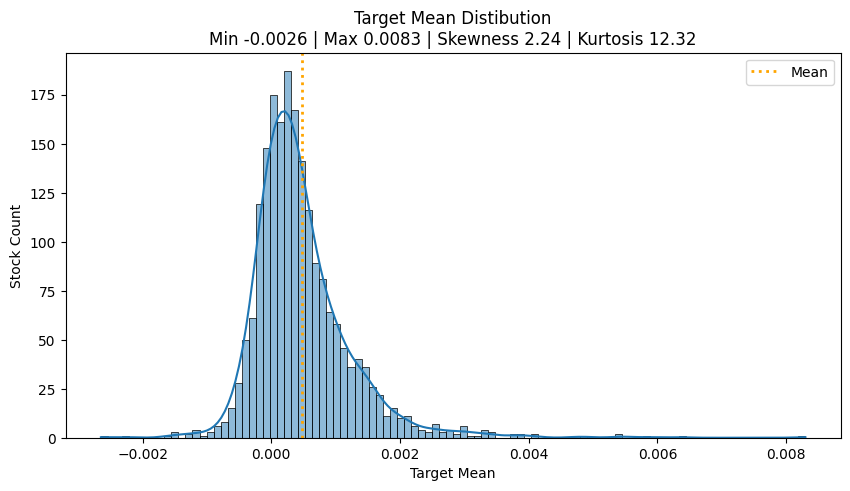

In [ ]:
#Standard Deviation Distribution of 'Target' column

target_mean_per_stock = train.groupby(['SecuritiesCode'])['Target'].mean()

target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2,
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

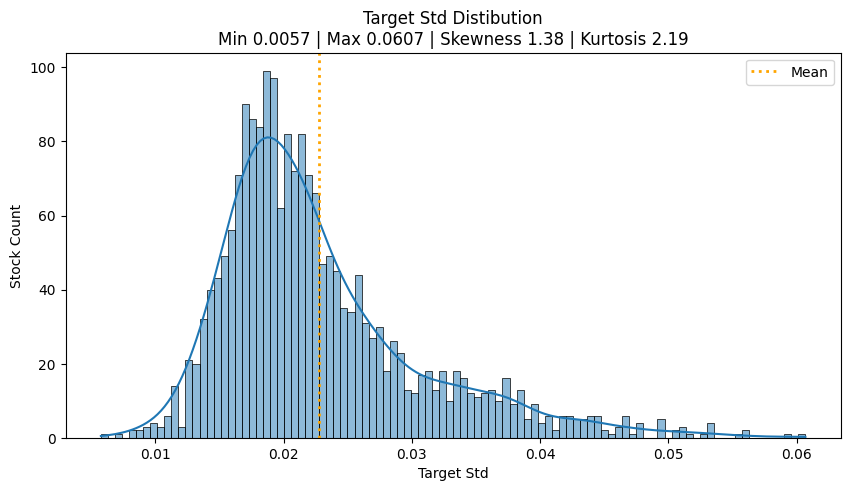

In [ ]:
#Mean Distribution of 'Target' column

target_std_per_stock = train.groupby(['SecuritiesCode'])['Target'].std()

target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2,
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

In [ ]:
stock_list.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False


In [ ]:
def process_stock_list(stock_list):
    stock_list['SectorName'] = [i.rstrip().lower().capitalize() for i in stock_list['17SectorName']]
    stock_list['Name'] = [i.rstrip().lower().capitalize() for i in stock_list['Name']]
    return stock_list

def merge_train_stock(train, stock_list):
    train_df = train.merge(stock_list[['SecuritiesCode', 'Name', 'SectorName']], on='SecuritiesCode', how='left')
    train_df['Year'] = train_df['Date'].dt.year
    return train_df

In [ ]:
stock_list = process_stock_list(stock_list)
train_df = merge_train_stock(train, stock_list)

print(train_df.columns)

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'Name', 'SectorName', 'Year'],
      dtype='object')


In [ ]:
train_df.head(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,SectorName,Year
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"Kyokuyo co.,ltd.",Foods,2017
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324,"Nippon suisan kaisha,ltd.",Foods,2017
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154,Maruha nichiro corporation,Foods,2017
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053,"Kaneko seeds co.,ltd.",Foods,2017
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026,Sakata seed corporation,Foods,2017


In [ ]:
train_df.tail(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,SectorName,Year
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,Sac's bar holdings inc.,Retail trade,2021
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,Gecoss corporation,Commercial & wholesale trade,2021
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,"Yamazawa co.,ltd.",Retail trade,2021
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,Yamaya corporation,Retail trade,2021
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414,"Belluna co.,ltd.",Retail trade,2021


In [ ]:
# Group by 'SecuritiesCode' and count the number of rows for each
securities_counts = train_df.groupby('SecuritiesCode').size()

# Display the count of rows for all SecuritiesCodes
print(securities_counts)


SecuritiesCode
1301    1202
1332    1202
1333    1202
1375     297
1376    1202
        ... 
9990    1202
9991    1202
9993    1202
9994    1202
9997    1202
Length: 2000, dtype: int64


In [ ]:
# Check missing values
missing_data = train_df.isnull().sum().to_frame(name='Missing Count')
missing_data['Missing Percentage'] = train_df.isnull().mean() * 100

# Print the result
print(missing_data)

# print("\n")
# print(stock_list.isnull().sum())

                  Missing Count  Missing Percentage
RowId                         0            0.000000
Date                          0            0.000000
SecuritiesCode                0            0.000000
Open                       7608            0.326169
High                       7608            0.326169
Low                        7608            0.326169
Close                      7608            0.326169
Volume                        0            0.000000
AdjustmentFactor              0            0.000000
ExpectedDividend        2313666           99.191222
SupervisionFlag               0            0.000000
Target                      238            0.010204
Name                          0            0.000000
SectorName                    0            0.000000
Year                          0            0.000000


In [ ]:
# Drop rows where 'Target' is NaN
train_df = train_df.dropna(subset=['Target'])

In [ ]:
def adjust_price(price):
    price.loc[:, "Date"] = pd.to_datetime(price.loc[:, "Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))
        df = df.sort_values("Date")
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    price = price.sort_values(["SecuritiesCode", "Date"])
    #Forward-filling to propagate the last valid value
    price[['Open', 'High', 'Low', 'Close']] = price[['Open', 'High', 'Low', 'Close']].fillna(method='ffill')

    # # Check missing values
    # missing_data =price.isnull().sum().to_frame(name='Missing Count')
    # missing_data['Missing Percentage'] = price.isnull().mean() * 100

    # # Print the result
    # print(missing_data)
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    # Sort the dataset by Date in ascending order
    price = price.sort_values("Date", ascending=True)

    print(price)

    price.set_index("Date", inplace=True)
    return price

In [ ]:
#calculate ATR for indicate market volatility
def average_true_range(df, high, low, close, n=14):
    data = df.copy()
    high_low = data[high] - data[low]
    high_close = np.abs(data[high] - data[close].shift())
    low_close = np.abs(data[low] - data[close].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(n).sum()/n
    df['ATR'] = atr
    return df

In [ ]:
#Feature generation
train_df = adjust_price(train_df)

if 'Date' not in train_df.columns:
    train_df.reset_index(inplace=True)

train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['Year'] = train_df['Date'].dt.year
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek


# Create lag features
train_df['Lag_Close_1'] = train_df.groupby('SecuritiesCode')['Close'].shift(1)
train_df['Lag_Close_5'] = train_df.groupby('SecuritiesCode')['Close'].shift(5)
train_df['Lag_Volume_1'] = train_df.groupby('SecuritiesCode')['Volume'].shift(1)

# Calculate the rolling volatility for each period (using log returns) and add a new column to the DataFrame
train_df.loc[:, "Volatility_30Day".format(30)] = np.log(train_df['AdjustedClose']).groupby(train_df["SecuritiesCode"]).diff().rolling(30).std()

# Calculate the rolling mean of AdjustedClose for each period and add a new column to the DataFrame
train_df.loc[:, "MovingAvg_20Day".format(20)] = train_df.groupby("SecuritiesCode")['AdjustedClose'].rolling(window=20).mean().values

train_df = average_true_range(train_df, 'High', 'Low', 'AdjustedClose', 5)

train_df = train_df.dropna(subset=['Lag_Close_1', 'Lag_Close_5', 'Lag_Volume_1'])
train_df = train_df.dropna(subset=['Volatility_30Day', 'MovingAvg_20Day'])

In [ ]:
print(train_df.isnull().sum())


Date                                0
RowId                               0
SecuritiesCode                      0
Open                                0
High                                0
Low                                 0
Close                               0
Volume                              0
AdjustmentFactor                    0
ExpectedDividend              2253505
SupervisionFlag                     0
Target                              0
Name                                0
SectorName                          0
Year                                0
CumulativeAdjustmentFactor          0
AdjustedClose                       0
Day                                 0
Month                               0
DayOfWeek                           0
Lag_Close_1                         0
Lag_Close_5                         0
Lag_Volume_1                        0
Volatility_30Day                    0
MovingAvg_20Day                     0
ATR                                 0
dtype: int64

In [ ]:
# Get the unique SecuritiesCodes
unique_securities = train_df['SecuritiesCode'].unique()

# Group by 'SecuritiesCode' and select the last row for each group
testset = train_df.groupby('SecuritiesCode').tail(1)

# Remove these rows from the original DataFrame to create the training set
train_df = train_df[~train_df.index.isin(testset.index)]

# Define the file path for saving the test data
test_data_path = "/content/drive/My Drive/Stock data/test_data.csv"

# Save the test dataset to a CSV file
testset.to_csv(test_data_path, index=False)

print(f"Test data saved to {test_data_path}")


Test data saved to /content/drive/My Drive/Stock data/test_data.csv


In [ ]:
# Parameters for LGBM
params = {
    'n_estimators': 2000,
    'num_leaves': 69,
    'learning_rate': 0.0041,
    'colsample_bytree': 0.64,
    'subsample': 0.97,
    'reg_alpha': 1.27,
    'reg_lambda': 1.0,
    'metric': 'rmse',
    'random_state': 21,
    'verbose': -1,
}

# Define feature set and target
X = train_df[['SecuritiesCode','Day','Month','Year', 'Close', 'Lag_Close_1', 'Lag_Close_5', 'Lag_Volume_1','AdjustedClose','Volatility_30Day','MovingAvg_20Day','ATR']]
y = train_df['Target']

# Convert 'SecuritiesCode' to a categorical feature
X['SecuritiesCode'] = X['SecuritiesCode'].astype('category')

# TimeSeriesSplit for time-series cross-validation
ts_fold = TimeSeriesSplit(n_splits=5, gap=100)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    print(f"\n=== Fold {fold + 1} ===")
    X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]

    # Train LightGBM model
    gbm = LGBMRegressor(**params).fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='mae',
        categorical_feature=['SecuritiesCode']  # Tell LightGBM that 'SecuritiesCode' is categorical
    )

    # Predict for training and validation sets
    y_train_pred = gbm.predict(X_train)
    y_val_pred = gbm.predict(X_val)

    # Compute metrics for the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_directional_accuracy = np.mean(np.sign(y_train.values) == np.sign(y_train_pred)) * 100

    # Compute metrics for the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_directional_accuracy = np.mean(np.sign(y_val.values) == np.sign(y_val_pred)) * 100

    # Print metrics for the training set
    print(f"Training Set - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, Directional Accuracy: {train_directional_accuracy:.2f}%")

    # Print metrics for the validation set
    print(f"Validation Set - RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, Directional Accuracy: {val_directional_accuracy:.2f}%")

# Train the final model on the entire dataset
final_model = LGBMRegressor(**params).fit(X, y, categorical_feature=['SecuritiesCode'])




=== Fold 1 ===
Training Set - RMSE: 0.0200, MAE: 0.0131, Directional Accuracy: 59.02%
Validation Set - RMSE: 0.0261, MAE: 0.0173, Directional Accuracy: 57.32%

=== Fold 2 ===
Training Set - RMSE: 0.0229, MAE: 0.0149, Directional Accuracy: 59.49%
Validation Set - RMSE: 0.0231, MAE: 0.0154, Directional Accuracy: 58.47%

=== Fold 3 ===
Training Set - RMSE: 0.0228, MAE: 0.0150, Directional Accuracy: 60.10%
Validation Set - RMSE: 0.0239, MAE: 0.0161, Directional Accuracy: 60.13%

=== Fold 4 ===
Training Set - RMSE: 0.0230, MAE: 0.0152, Directional Accuracy: 60.60%
Validation Set - RMSE: 0.0194, MAE: 0.0131, Directional Accuracy: 60.00%

=== Fold 5 ===
Training Set - RMSE: 0.0222, MAE: 0.0147, Directional Accuracy: 61.12%
Validation Set - RMSE: 0.0186, MAE: 0.0125, Directional Accuracy: 59.46%


In [ ]:

# Define the path to save the model
model_path = "/content/drive/My Drive/Stock data/final_model.pkl"

# Check if the model file already exists
if os.path.exists(model_path):
    # Delete the existing model file
    os.remove(model_path)
    print(f"Existing model at '{model_path}' deleted.")

# Save the new model
joblib.dump(final_model, model_path)
print(f"New model saved at '{model_path}'")


Existing model at '/content/drive/My Drive/Stock data/final_model.pkl' deleted.
New model saved at '/content/drive/My Drive/Stock data/final_model.pkl'


In [ ]:
# Define the path to the saved model
model_path = "/content/drive/My Drive/Stock data/final_model.pkl"

# Load the saved model
final_model = joblib.load(model_path)
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
print(final_model)  # Prints the model details

LGBMRegressor(colsample_bytree=0.64, learning_rate=0.0041, metric='rmse',
              n_estimators=2000, num_leaves=69, random_state=21, reg_alpha=1.27,
              reg_lambda=1.0, subsample=0.97, verbose=-1)


In [ ]:
# Define the path to the saved test set
test_data_path = "/content/drive/My Drive/Stock data/test_data.csv"

# Load the saved model
testset = pd.read_csv(test_data_path)
print("Test data loaded successfully!")

Test data loaded successfully!


In [ ]:
# Ensure the test set has the same feature columns
X_test = testset[['SecuritiesCode', 'Day', 'Month', 'Year', 'Close', 'Lag_Close_1',
                            'Lag_Close_5', 'Lag_Volume_1', 'AdjustedClose',
                            'Volatility_30Day', 'MovingAvg_20Day', 'ATR']]

# Convert 'SecuritiesCode' to categorical, as done during training
X_test['SecuritiesCode'] = X_test['SecuritiesCode'].astype('category')

# Predict using the trained model
predictions = final_model.predict(X_test)

# Add predictions to the test data for better visualization
testset['Predicted_Target'] = predictions

# Display the predictions
print("Predictions for Test Data:")
print(testset[['SecuritiesCode','Name', 'Date','Predicted_Target']].head())



Predictions for Test Data:
   SecuritiesCode                        Name        Date  Predicted_Target
0            1301            Kyokuyo co.,ltd.  2021-12-03          0.002451
1            1332   Nippon suisan kaisha,ltd.  2021-12-03          0.002319
2            1333  Maruha nichiro corporation  2021-12-03          0.002247
3            1375   Yukiguni maitake co.,ltd.  2021-12-03          0.002258
4            1376       Kaneko seeds co.,ltd.  2021-12-03          0.002690


In [ ]:
# Sort the test data by predicted target values in descending order
sorted_test_data = testset.sort_values(by='Predicted_Target', ascending=False)

# Select the top 5 companies to buy stocks (highest positive predictions)
best_to_buy = sorted_test_data.head(5)

# Select the top 5 companies to sell stocks (most negative predictions)
best_to_sell = sorted_test_data.tail(5)

# Display the results
print("Best Companies to Buy Stocks:")
print(best_to_buy[['SecuritiesCode', 'Predicted_Target']])

print("\nBest Companies to Sell Stocks:")
print(best_to_sell[['SecuritiesCode', 'Predicted_Target']])

Best Companies to Buy Stocks:
      SecuritiesCode  Predicted_Target
305             3031          0.008838
433             3612          0.006955
991             6182          0.006791
1002            6232          0.005602
695             4572          0.005585

Best Companies to Sell Stocks:
      SecuritiesCode  Predicted_Target
610             4323         -0.003873
163             2307         -0.003971
762             4771         -0.004077
1138            6616         -0.004753
1278            7036         -0.004935


In [ ]:
# # Define feature set and target
# X = train_df[['SecuritiesCode','Day','Month','Year', 'Close', 'Lag_Close_1', 'Lag_Close_5',
#               'Lag_Volume_1', 'AdjustedClose', 'Volatility_30Day', 'MovingAvg_20Day', 'ATR']]
# y = train_df['Target']

# # Convert 'SecuritiesCode' to a categorical feature
# X['SecuritiesCode'] = X['SecuritiesCode'].astype('category')

# # TimeSeriesSplit for time-series cross-validation
# ts_fold = TimeSeriesSplit(n_splits=5, gap=100)

# # Objective function for Optuna
# def objective(trial):
#     # Define the search space for hyperparameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),
#         'metric': 'rmse',
#         'random_state': 21,
#         'verbose': -1,
#     }

#     rmse_scores = []  # Store RMSE scores for each fold

#     # TimeSeries cross-validation
#     for train_idx, val_idx in ts_fold.split(X, y):
#         X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
#         X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]

#         # Train the LightGBM model
#         model = LGBMRegressor(**params)
#         model.fit(
#             X_train, y_train,
#             eval_set=[(X_val, y_val)],
#             eval_metric='rmse',
#             categorical_feature=['SecuritiesCode'],
#             callbacks=[LightGBMPruningCallback(trial, 'rmse')]  # Pruning callback
#         )

#         # Predict and compute RMSE
#         y_val_pred = model.predict(X_val)
#         val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
#         rmse_scores.append(val_rmse)

#     # Return the average RMSE for all folds
#     return np.mean(rmse_scores)

# # Run Optuna optimization
# study = optuna.create_study(direction='minimize', study_name="LGBM Optimization")
# study.optimize(objective, n_trials=5, timeout=3600)

# # Print the best hyperparameters
# print("\nBest Hyperparameters:")
# print(study.best_params)

# # Train final model with the best hyperparameters
# best_params = study.best_params
# best_params['metric'] = 'rmse'  # Add metric explicitly

# final_model = LGBMRegressor(**best_params).fit(X, y, categorical_feature=['SecuritiesCode'])

# print("\nFinal Model Trained with Best Hyperparameters")

# # Predict on the training set
# y_pred = final_model.predict(X)

# # Compute detailed metrics
# final_rmse = np.sqrt(mean_squared_error(y, y_pred))
# final_mae = mean_absolute_error(y, y_pred)
# final_directional_accuracy = np.mean(np.sign(y.values) == np.sign(y_pred)) * 100

# print(f"\nDetailed Final Metrics:")
# print(f"Final RMSE: {final_rmse:.4f}")
# print(f"Final MAE: {final_mae:.4f}")
# print(f"Final Directional Accuracy: {final_directional_accuracy:.2f}%")

